In [1]:
import numpy as np
import nengo

from nengolib.synapses import DoubleExp
from nengolib.stats import ScatteredHypersphere

from nengo_extras.plot_spikes import cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Parameters

In [2]:
seed = 0
rng = np.random.RandomState(seed)
n_items = 6  # number of items in the d-dimensional vocabulary
d = 2  # dimensionality
n_pre = 105
n_neurons = 100
n_inh = 95
dt = 0.001
t = 1.0  # stimulus time for each item
n_cycles = 30  # number of times to loop through all items during training
T = t*n_items*n_cycles  # total training time
items = ScatteredHypersphere(surface=True).sample(n_items, d, rng=rng)  # evenly distribute items along the surface of the d-dimensional space

### Present inputs in a cyclic pattern, with order randomized every cycle

In [3]:
def make_stim():
    stim = np.zeros((int(T/dt)+2, d))
    time = 0
    for i in range(n_cycles):
        order = np.arange(0, n_items)
        rng.shuffle(order)
        for j in range(n_items):
            for k in range(int(t/dt)):
                stim[time] = items[order[j]]
                time += 1
    return stim

stim = make_stim()

def stim_func(t, dt=0.001):
    return stim[int(t/dt)]

# 1. Use VOJA learning rule to sparsify a population ```post```
Also compute various decoders/encoders/weights for future simulations: grab decoders for ```pre```, save VOJA-trained encoders for ```target```, and use PES learning to decode ```target``` activities

In [4]:
learning_rate_voja = 1e-3
learning_rate_pes = 1e-4
synapse = nengo.Lowpass(0.01)
smooth = DoubleExp(2e-2, 2e-1)  # used to filter spikes into activities for the learning rule
intercept = (np.dot(items, items.T) - np.eye(n_items)).flatten().max() # from Step 1 of https://www.nengo.ai/nengo/examples/learning/learn-associations.html
intercepts = nengo.dists.Uniform(intercept, 1)
max_rates = nengo.dists.Uniform(200, 400)

In [5]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
 
    voja = nengo.Voja(learning_rate=learning_rate_voja, post_synapse=None)  # trains pre-target connection
    pes = nengo.PES(learning_rate=learning_rate_pes) # trains target-output connection

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, learning_rule_type=voja)
    target_output = nengo.Connection(target, output, synapse=synapse, learning_rule_type=pes, function=lambda x: np.zeros(d))
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, target_output.learning_rule, synapse=None)
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_encoders = nengo.Probe(pre_target.learning_rule, "scaled_encoders")
    p_decoders = nengo.Probe(target_output, "weights")
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Save decoders, encoders, and weights

In [6]:
d_pre = sim.data[pre_target].weights
e_target = sim.data[p_encoders][-1].copy()
d_target = sim.data[p_decoders][-1].copy()
w_pre_target = np.dot(e_target, d_pre)

Confirm encoder learning has sparsified ```target```. Encoders should be clustered around the items defined in Model Parameters

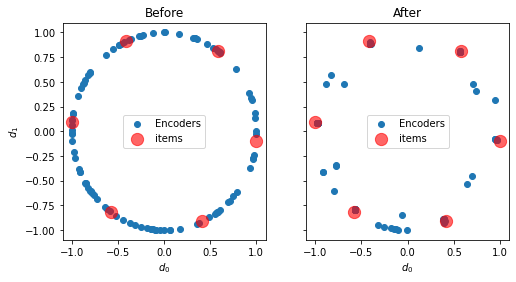

In [7]:
scale = (sim.data[target].gain / target.radius)[:, np.newaxis]
encoders_before = sim.data[p_encoders][0].copy() / scale
encoders_after = sim.data[p_encoders][-1].copy() / scale
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((8, 4)))
ax.scatter(encoders_before[:, 0], encoders_before[:, 1], label="Encoders")
ax.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax2.scatter(encoders_after[:, 0], encoders_after[:, 1], label="Encoders")
ax2.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax.set(xlabel=r'$d_0$', ylabel=r'$d_1$', title='Before')
ax2.set(xlabel=r'$d_0$', title='After')
ax.legend(loc='best')
ax2.legend(loc='best')

This should also be reflected in the spike rasters

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

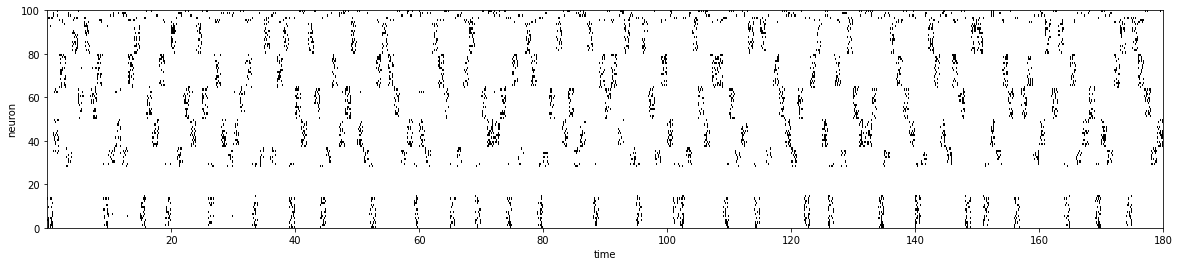

In [8]:
fig, ax = plt.subplots(figsize=((20, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_target], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

Confirm that an estimate of the input ```items``` can be recovered from ```target```

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

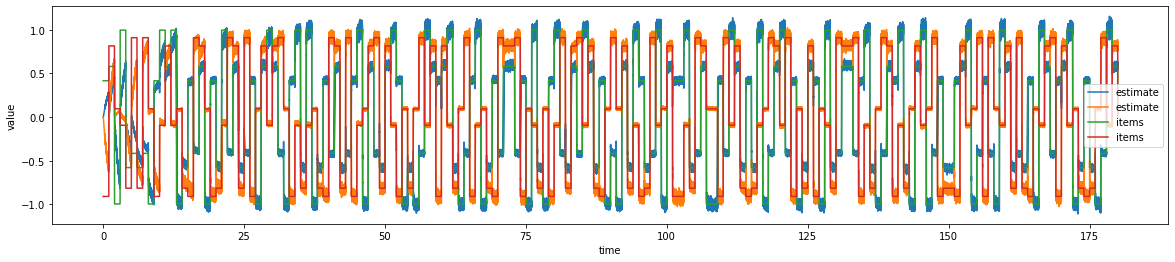

In [9]:
fig, ax = plt.subplots(figsize=((20, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

Test with learning removed: rebuild the network with all learning rules removed, just to be sure I haven't accidentally kept learning on :)

In [10]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
 
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    target_output = nengo.Connection(target, output, synapse=synapse, solver=nengo.solvers.NoSolver(d_target.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

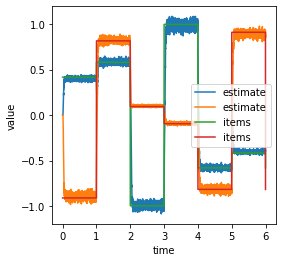

In [11]:
fig, ax = plt.subplots(figsize=((4, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

## Conclusion 1: using VOJA on a feedforward connection from ```pre``` can sparsify the activity of a population, as expected.
VOJA learning rule on the ```pre-target``` connection can sparsify representations in ```target```. This learning rule does not require target activities or recurrent excitation/inhibition.

# 2. Define a custom node that will implement our online learning rule
 - Feed in activites from ```pre```, ```post```, and ```target``` as inputs to the node, making sure to index them properly
 - Update the weight matrix from ```pre``` to ```post``` with the learning rule, and have the node return ```np.dot(self.weights.T, a_pre)``` to implement the feedforward connection
 - To update ```self.weights```, define a tensor called ```e_post``` that has shape (n_pre, n_post, d). Loop through each of its entries on every timestep and increase or decrease the entry according to
   - the magnitude of presynaptic activity
   - the sign of the presynaptic decoder for that dimension
   - the signed difference between the ```target``` activity and the ```post``` 
 - Then update each entry in ```self.weights``` by doing ```np.dot(self.d_pre[pre], self.e_post[pre, post])```

In [12]:
class CustomLearningNode(nengo.Node):
    def __init__(self, pre, post, target, d_pre, learning_rate, exc=False, inh=False):
        self.pre = pre
        self.post = post
        self.target = target
        self.size_in = pre.n_neurons + post.n_neurons + target.n_neurons
        self.size_out = post.n_neurons
        self.d_pre = d_pre
        # 'encoders' is a connection-specific tensor used to compute weights; shape (Npre, Npost, d)
        self.e_post = np.zeros((pre.n_neurons, post.n_neurons, d_pre.shape[1]))
        self.weights = np.zeros((pre.n_neurons, post.n_neurons))
        self.learning_rate = learning_rate
        self.exc = exc
        self.inh = inh
        assert self.exc==False or self.inh==False, "Can't force excitatory and inhibitory weights"
        super().__init__(self.step, size_in=self.size_in, size_out=self.size_out)

    def step(self, t, x, update_every=10, dt=1e-3, dAmin=1e0):
        a_pre = x[:self.pre.n_neurons]  # divide inputs to node into corresponding activities
        a_post = x[self.pre.n_neurons: self.pre.n_neurons+self.post.n_neurons]
        a_target = x[self.pre.n_neurons+self.post.n_neurons:]
        if int(t/dt) % update_every == 0: # only update periodically (expensive computation)
            for post in range(self.post.n_neurons):
                dA = a_target[post] - a_post[post]  # delta used for update
                if np.abs(dA)<dAmin: continue  # skip update if post activity is close to target activity
                for pre in range(self.pre.n_neurons):
                    for dim in range(self.d_pre.shape[1]): # each dimension of the 'encoder' is updated separately
                        sign = 1.0 if self.d_pre[pre, dim] >= 0 else -1.0 # sign ensures weight change is in the correct direction
                        dE = sign * self.learning_rate * a_pre[pre] # delta for that entry in the encoder matrix
                        self.e_post[pre, post, dim] += dA * dE
                    w = np.dot(self.d_pre[pre], self.e_post[pre, post]) # update corresponding entry in weight matrix
                    if self.exc and w < 0: w = 0 # enforce excitatory weights
                    if self.inh and w > 0: w = 0 # enforce inhibitory weights
                    self.weights[pre, post] = w # update weight matrix
        return np.dot(self.weights.T, a_pre)  # transmit weighted activity from pre to post

# 3. Can this learning rule sparsify ```post``` given ```target``` neural activities?
Train the weights on the ```pre-post``` connection so that ```post```'s activities converge to ```target```'s activities; also train readout decoders for ```post``` with PES

In [13]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, seed=seed+3, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    pes = nengo.PES(learning_rate=learning_rate_pes)
    learning_node = CustomLearningNode(pre, post, target, d_pre.T, 3e-7)

    nengo.Connection(pre.neurons, learning_node[:pre.n_neurons], synapse=pes)
    nengo.Connection(post.neurons, learning_node[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node, post.neurons, synapse=None)
                  
    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    post_output = nengo.Connection(post, output, synapse=synapse, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_neurons, d))))  # initial decoders are zero
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, post_output.learning_rule, synapse=None)
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_decoders = nengo.Probe(post_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [14]:
d_post = sim.data[p_decoders][-1].copy()
w_pre_post = learning_node.weights

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

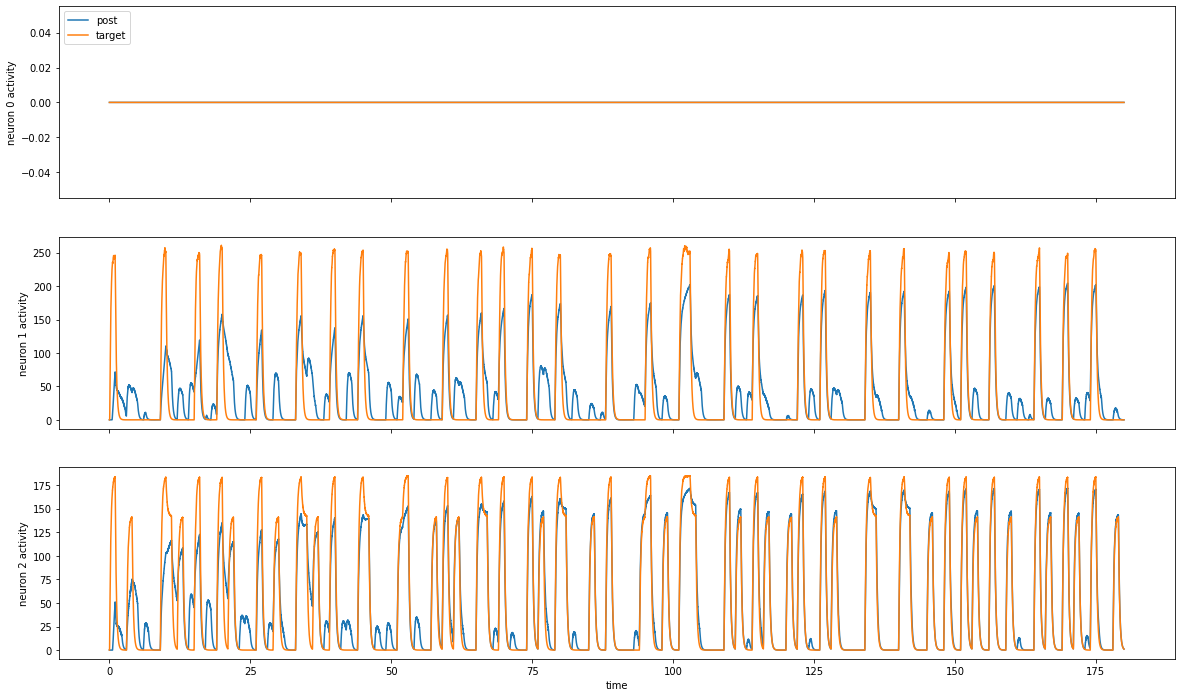

In [15]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((20, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

Activities are converging, but some error remains. Perhaps this could be reduced with fine-tuning (todo).

Test with learning removed

In [16]:
w_pre_post = learning_node.weights.copy()

with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, seed=seed+3, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))
    post_output = nengo.Connection(post, output, synapse=synapse, solver=nengo.solvers.NoSolver(d_post.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

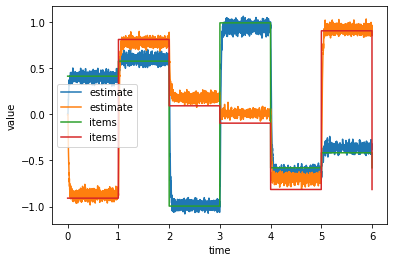

In [17]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

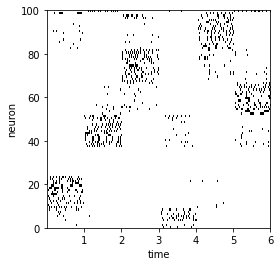

In [18]:
fig, ax = plt.subplots(figsize=((4, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_post], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

## Conclusion 3: this online learning rule, applied to the feedforward ```pre-post``` connection, can sparsify representations in ```post```.
It requires a set of ```target``` acitivites which are already sparse, but does not require recurrent connectivity.

# 4. Increase biological realism, and see if the learning rule still works.
Specify an adaptive neuron type for ```post```. Use ```DoubleExp``` synapses with AMPA parameters for stricly-excitatory connections from ```pre``` to ```post``` 

In [19]:
AMPA = DoubleExp(0.55e-3, 2.2e-3)
post_type = nengo.AdaptiveLIF()  # todo: find biological parameters

In [20]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, neuron_type=post_type, seed=seed+3, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    pes = nengo.PES(learning_rate=learning_rate_pes)
    learning_node = CustomLearningNode(pre, post, target, d_pre.T, 3e-7, exc=True)  # don't allow negative weights

    nengo.Connection(pre.neurons, learning_node[:pre.n_neurons], synapse=AMPA)
    nengo.Connection(post.neurons, learning_node[pre.n_neurons: pre.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target.neurons, learning_node[pre.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node, post.neurons, synapse=None)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target = nengo.Connection(pre, target, synapse=synapse, solver=nengo.solvers.NoSolver(w_pre_target.T, weights=True))
    post_output = nengo.Connection(post, output, synapse=AMPA, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_neurons, d))))  # initial decoders are zero
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, post_output.learning_rule, synapse=None)
    
    p_input = nengo.Probe(input, synapse=None)
    p_target = nengo.Probe(target.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_node = nengo.Probe(learning_node, synapse=None)
    p_decoders = nengo.Probe(post_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [28]:
d_post = sim.data[p_decoders][-1].copy()
w_pre_post = learning_node.weights
assert(np.all(w_pre_post>=0))  # double-check that weights are excitatory

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

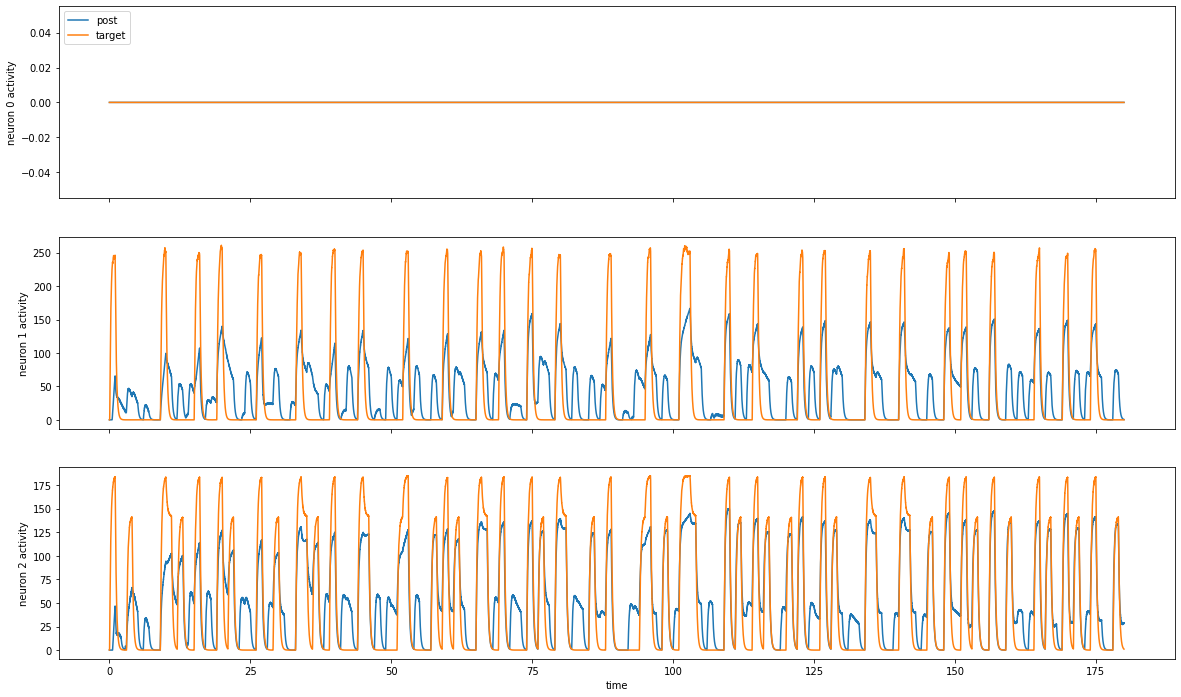

In [22]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((20, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,0], label='target')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,1], label='target')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target], dt=dt)[:,2], label='target')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

Convergence is less good with biological realism, but still OK

Test with learning removed

In [23]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())

    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, neuron_type=post_type, seed=seed+3, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_post, weights=True))
    post_output = nengo.Connection(post, output, synapse=AMPA, solver=nengo.solvers.NoSolver(d_post.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    
with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

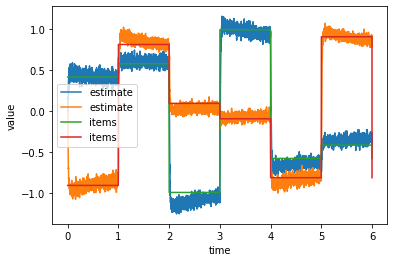

In [24]:
a_post = synapse.filt(sim.data[p_post], dt=dt)
estimate = np.dot(a_post, d_post.T)
fig, ax = plt.subplots()
ax.plot(sim.trange(), estimate, label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value')

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron')]

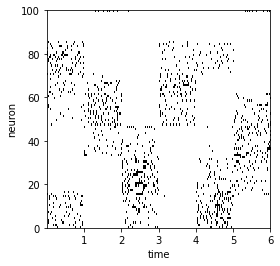

In [25]:
fig, ax = plt.subplots(figsize=((4, 4)))
plot_spikes(
    *merge(
        *cluster(
            *sample_by_variance(sim.trange(), sim.data[p_post], num=n_neurons, filter_width=0.01),
        filter_width=0.01),
    num=n_neurons))
ax.set(xlabel='time', ylabel='neuron')

## Conclusion 4: the online learning rule can account for adaptive neurons, complex synapses, and strictly-excitatory connections

# 5. Try and achieve sparsity using only lateral inhibition.
Assume a random excitatory connection between ```pre``` and ```post```. Train a connection between ```post``` and a new inhibitory population ```inh``` with (AMPA?) synapses so that ```inh``` approaches the activity of ```target_inh```, which is sparse. Learn the ```post-inh``` and ```inh-post``` connection weights simultaneously, but do not update ```pre-post```.

In [92]:
NMDA = DoubleExp(10.6e-3, 285e-3)
GABA = DoubleExp(0.5e-3, 1.5e-3)
AMPA = DoubleExp(0.55e-3, 2.2e-3)
smooth = DoubleExp(1e-3, 2e-1)
post_type = nengo.AdaptiveLIF(tau_n=1, inc_n=0.02)  # todo: find biological parameters
inh_type = nengo.AdaptiveLIF(tau_n=1, inc_n=0.01)  # todo: find biological parameters
learning_rate_voja_post = 1e-3
learning_rate_voja_inh = 2e-3
learning_rate_pes = 1e-2
max_rates_post = nengo.dists.Uniform(200, 400)  # todo: test plausible firing rates
max_rates_inh = nengo.dists.Uniform(100, 300)

### 5.1 VOJA learning for ```target_post``` and ```target_inh```

In [93]:
with nengo.Network() as network:
    # inputs, outputs, error populations, and ensembles
    input = nengo.Node(stim_func)
    output_post = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    output_inh = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error_post = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error_inh = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    target_post = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates_post, seed=seed+1)
    target_inh = nengo.Ensemble(n_inh, d, intercepts=intercepts, max_rates=max_rates_inh, seed=seed+2)

    # VOJA and PES learning rules
    pes = nengo.PES(learning_rate=learning_rate_pes)
    voja_post = nengo.Voja(learning_rate=learning_rate_voja_post, post_synapse=AMPA)
    voja_inh = nengo.Voja(learning_rate=learning_rate_voja_inh, post_synapse=GABA)

    # feedforward connections with encoder learning
    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target_post = nengo.Connection(pre, target_post, synapse=AMPA, learning_rule_type=voja_post)
    pre_target_inh = nengo.Connection(pre, target_inh, synapse=AMPA, learning_rule_type=voja_inh)

    # feedforward connections with decoder learning
    post_output = nengo.Connection(target_post, output_post, synapse=AMPA, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_neurons, d))))
    input_error_post = nengo.Connection(input, error_post, transform=-1, synapse=None)
    output_error_post = nengo.Connection(output_post, error_post, synapse=None)
    error_signal_post = nengo.Connection(error_post, post_output.learning_rule, synapse=None)
    inh_output = nengo.Connection(target_inh, output_inh, synapse=GABA, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_inh, d))))
    input_error_inh = nengo.Connection(input, error_inh, transform=-1, synapse=None)
    output_error_inh = nengo.Connection(output_inh, error_inh, synapse=None)
    error_signal_inh = nengo.Connection(error_inh, inh_output.learning_rule, synapse=None)
    
    # probes
    p_input = nengo.Probe(input, synapse=None)
    p_target_post = nengo.Probe(target_post.neurons, synapse=None)
    p_target_inh = nengo.Probe(target_inh.neurons, synapse=None)
    p_output_post = nengo.Probe(output_post, synapse=None)
    p_output_inh = nengo.Probe(output_inh, synapse=None)
    p_encoders_post = nengo.Probe(pre_target_post.learning_rule, "scaled_encoders")
    p_encoders_inh = nengo.Probe(pre_target_inh.learning_rule, "scaled_encoders")
    p_decoders_post = nengo.Probe(post_output, "weights")
    p_decoders_inh = nengo.Probe(inh_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

d_pre_post = sim.data[pre_target_post].weights
d_pre_inh = sim.data[pre_target_inh].weights
d_target_post = sim.data[p_decoders_post][-1].copy()
d_target_inh = sim.data[p_decoders_inh][-1].copy()
e_target_post = sim.data[p_encoders_post][-1].copy()
e_target_inh = sim.data[p_encoders_inh][-1].copy()
w_pre_target_post = np.dot(e_target_post, d_pre_post)
w_pre_target_inh = np.dot(e_target_inh, d_pre_inh)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

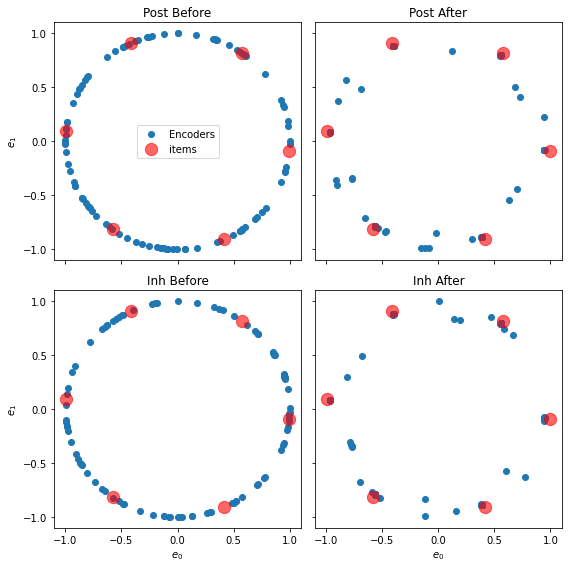

In [94]:
scale_post = (sim.data[target_post].gain / target_post.radius)[:, np.newaxis]
encoders_before_post = sim.data[p_encoders_post][0].copy() / scale_post
encoders_after_post = sim.data[p_encoders_post][-1].copy() / scale_post
scale_inh = (sim.data[target_inh].gain / target_inh.radius)[:, np.newaxis]
encoders_before_inh = sim.data[p_encoders_inh][0].copy() / scale_inh
encoders_after_inh = sim.data[p_encoders_inh][-1].copy() / scale_inh

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=((8, 8)))
ax.scatter(encoders_before_post[:, 0], encoders_before_post[:, 1], label="Encoders")
ax.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax2.scatter(encoders_after_post[:, 0], encoders_after_post[:, 1], label="Encoders")
ax2.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax.set(ylabel=r'$e_1$', yticks=np.array([-1, -0.5, 0, 0.5, 1.0]), title='Post Before')
ax2.set(title='Post After')
ax3.scatter(encoders_before_inh[:, 0], encoders_before_inh[:, 1], label="Encoders")
ax3.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax4.scatter(encoders_after_inh[:, 0], encoders_after_inh[:, 1], label="Encoders")
ax4.scatter(items[:, 0], items[:, 1], c="red", s=150, alpha=0.6, label="items")
ax3.set(xlabel=r'$e_0$', ylabel=r'$e_1$', yticks=np.array([-1, -0.5, 0, 0.5, 1.0]), title='Inh Before')
ax4.set(xlabel=r'$e_0$', title='Inh After')
ax.legend(loc='best')
plt.tight_layout()

### 5.2 Choose a random ```w_pre_post``` and ensure ```post``` has default activity

In [95]:
w_pre_post_fixed = rng.uniform(0, 1e-3, ((n_pre, n_neurons)))

with nengo.Network() as network:
    input = nengo.Node(stim_func)
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    post = nengo.Ensemble(n_neurons, d, neuron_type=post_type, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))
    target_post = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates_post, seed=seed+1)

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_post_fixed, weights=True))
    pre_target_post = nengo.Connection(pre, target_post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_target_post.T, weights=True))
        
    p_input = nengo.Probe(input, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_target_post = nengo.Probe(target_post.neurons, synapse=None)

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

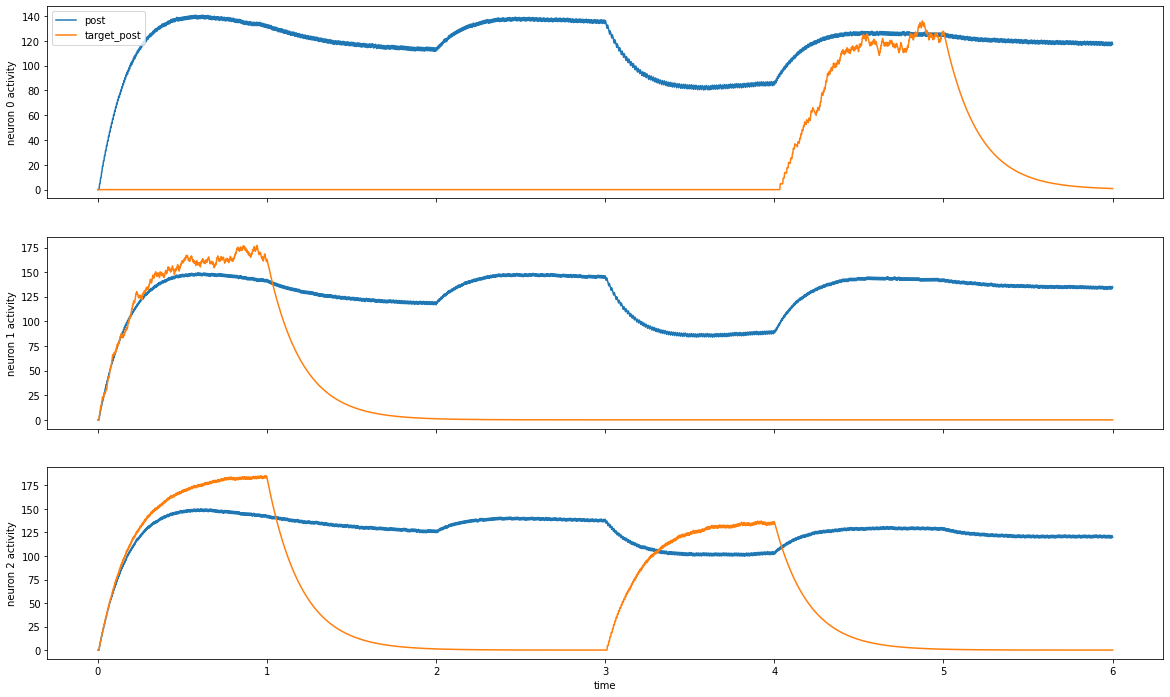

In [96]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((20, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target_post], dt=dt)[:,0], label='target_post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target_post], dt=dt)[:,1], label='target_post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target_post], dt=dt)[:,2], label='target_post')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

## [5.3 onwards]: work in progress

We want lateral inhibition from ```inh``` to sparsify ```post```, but because ```inh``` is only activated by ```post```, there is a lot of feedback that the learning rule must work with. If we train one direction of the feedback before the other (```post-inh``` or ```inh-post```), the second stage will disrupt the encoding of the presynaptic population. So the first thing to try is learning both connections simultaneously.

### 5.3 Train ```post-inh``` and ```inh-post```
Use ```d_target_inh``` as approximately-correct decoders for ```inh``` when doing encoder learning for ```inh-post```

In [121]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    error = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
    
    target_post = nengo.Ensemble(n_neurons, d, intercepts=intercepts, max_rates=max_rates_post, seed=seed+1)
    target_inh = nengo.Ensemble(n_inh, d, intercepts=intercepts, max_rates=max_rates_inh, seed=seed+1)
    post = nengo.Ensemble(n_neurons, d, neuron_type=post_type, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))
    inh = nengo.Ensemble(n_inh, d, neuron_type=inh_type, seed=seed+2, gain=np.ones((n_inh)), bias=np.zeros((n_inh)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_target_post = nengo.Connection(pre, target_post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_target_post.T, weights=True))
    pre_target_inh = nengo.Connection(pre, target_inh, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_target_inh.T, weights=True))
    pre_post = nengo.Connection(pre, post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_post_fixed, weights=True))
    
    learning_node_post_inh = CustomLearningNode(post, inh, target_inh, d_target_post.T, 3e-7, exc=True)
    learning_node_inh_post = CustomLearningNode(inh, post, target_post, d_target_inh.T, 3e-7, inh=True)

    nengo.Connection(post.neurons, learning_node_post_inh[:post.n_neurons], synapse=AMPA)
    nengo.Connection(inh.neurons, learning_node_post_inh[post.n_neurons: post.n_neurons+inh.n_neurons], synapse=smooth)
    nengo.Connection(target_inh.neurons, learning_node_post_inh[post.n_neurons+inh.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node_post_inh, inh.neurons, synapse=None)
    
    nengo.Connection(inh.neurons, learning_node_inh_post[:inh.n_neurons], synapse=GABA)
    nengo.Connection(post.neurons, learning_node_inh_post[inh.n_neurons: inh.n_neurons+post.n_neurons], synapse=smooth)
    nengo.Connection(target_post.neurons, learning_node_inh_post[inh.n_neurons+post.n_neurons: ], synapse=smooth)
    nengo.Connection(learning_node_inh_post, post.neurons, synapse=None)
    
    post_output = nengo.Connection(post, output, synapse=AMPA, learning_rule_type=pes, solver=nengo.solvers.NoSolver(np.zeros((n_neurons, d))))  # initial decoders are zero
    input_error = nengo.Connection(input, error, transform=-1, synapse=None)
    output_error = nengo.Connection(output, error, synapse=None)
    error_signal = nengo.Connection(error, post_output.learning_rule, synapse=None)

    
    p_input = nengo.Probe(input, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_target_post = nengo.Probe(target_post.neurons, synapse=None)
    p_target_inh = nengo.Probe(target_inh.neurons, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_inh = nengo.Probe(inh.neurons, synapse=None)
    p_decoders_post = nengo.Probe(post_output, "weights")

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(T)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [122]:
w_post_inh = learning_node_post_inh.weights
w_inh_post = learning_node_inh_post.weights
d_post = sim.data[p_decoders_post][-1].copy()

Are ```inh``` activities converging to ```target_inh```?

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

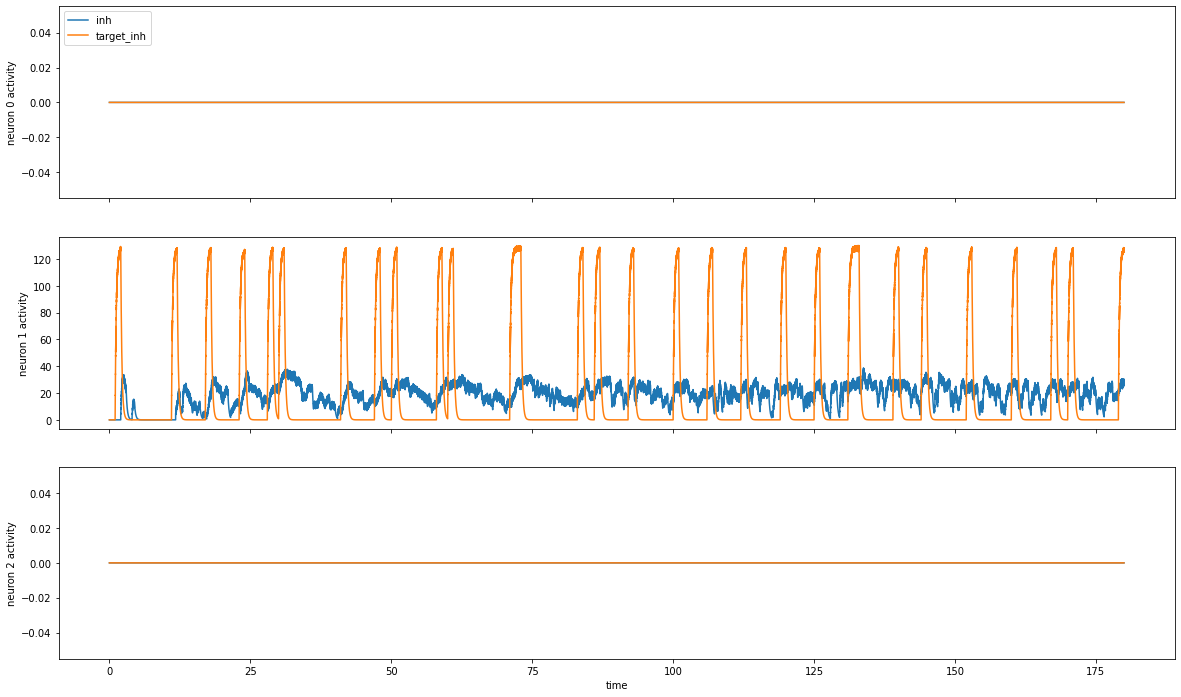

In [123]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((20, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_inh], dt=dt)[:,10], label='inh')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target_inh], dt=dt)[:,10], label='target_inh')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_inh], dt=dt)[:,11], label='inh')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target_inh], dt=dt)[:,11], label='target_inh')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_inh], dt=dt)[:,12], label='inh')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target_inh], dt=dt)[:,12], label='target_inh')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

Are ```post``` activities converging to ```target_post```?

[Text(0.5, 0, 'time'), Text(0, 0.5, 'neuron 2 activity')]

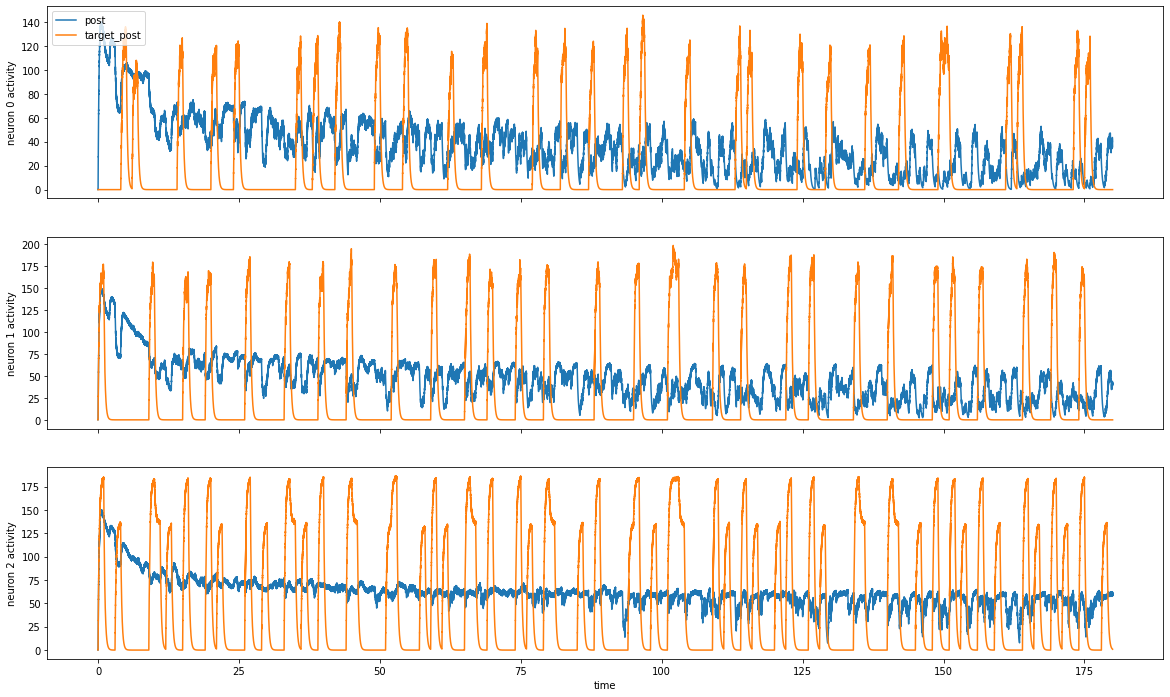

In [124]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((20, 12)), sharex=True)
ax.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,0], label='post')
ax.plot(sim.trange(), smooth.filt(sim.data[p_target_post], dt=dt)[:,0], label='target_post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,1], label='post')
ax2.plot(sim.trange(), smooth.filt(sim.data[p_target_post], dt=dt)[:,1], label='target_post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_post], dt=dt)[:,2], label='post')
ax3.plot(sim.trange(), smooth.filt(sim.data[p_target_post], dt=dt)[:,2], label='target_post')
ax.legend(loc='upper left')
ax.set(ylabel='neuron 0 activity')
ax2.set(ylabel='neuron 1 activity')
ax3.set(xlabel='time', ylabel='neuron 2 activity')

Is the decoded estimate improving?

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value'), (-1.0, 1.0)]

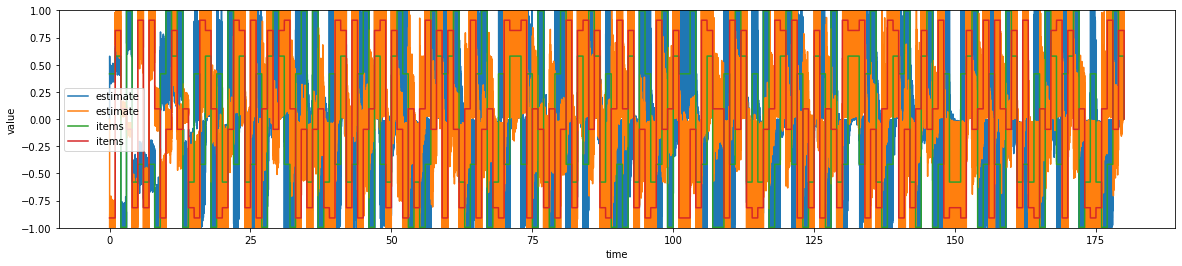

In [125]:
fig, ax = plt.subplots(figsize=((20, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value', ylim=((-1, 1)))

### 5.4 Test with learning removed

In [126]:
with nengo.Network() as network:
    input = nengo.Node(stim_func)
    pre = nengo.Ensemble(n_pre, d, seed=seed)
    output = nengo.Ensemble(1, d, neuron_type=nengo.Direct()) 
    post = nengo.Ensemble(n_neurons, d, neuron_type=post_type, seed=seed+2, gain=np.ones((n_neurons)), bias=np.zeros((n_neurons)))
    inh = nengo.Ensemble(n_inh, d, neuron_type=inh_type, seed=seed+2, gain=np.ones((n_inh)), bias=np.zeros((n_inh)))

    input_pre = nengo.Connection(input, pre, synapse=None)
    pre_post = nengo.Connection(pre, post, synapse=AMPA, solver=nengo.solvers.NoSolver(w_pre_post_fixed, weights=True))
    post_inh = nengo.Connection(post, inh, synapse=AMPA, solver=nengo.solvers.NoSolver(w_post_inh, weights=True))
    inh_post = nengo.Connection(inh, post, synapse=GABA, solver=nengo.solvers.NoSolver(w_inh_post, weights=True))
    post_output = nengo.Connection(post, output, synapse=AMPA, solver=nengo.solvers.NoSolver(d_post.T, weights=False))
    
    p_input = nengo.Probe(input, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_post = nengo.Probe(post.neurons, synapse=None)
    p_inh = nengo.Probe(inh.neurons, synapse=None)

with nengo.Simulator(network, dt=dt) as sim:
    sim.run(t*n_items)

/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/neurons.py:402: RuntimeWarning: divide by zero encountered in log1p
  max_rates = 1.0 / (self.tau_ref - self.tau_rc * np.log1p(
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
/home/pduggins/.local/share/virtualenvs/online-sparsity-6Auzpoec/lib/python3.9/site-packages/nengolib/signal/system.py:196: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'), Text(0, 0.5, 'value'), (-1.0, 1.0)]

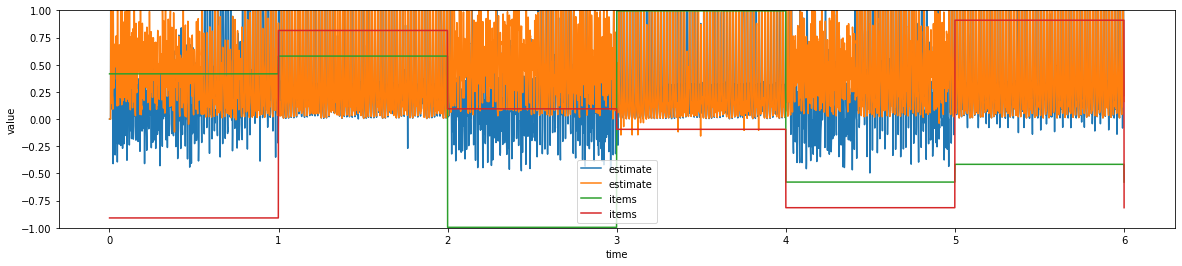

In [127]:
fig, ax = plt.subplots(figsize=((20, 4)))
ax.plot(sim.trange(), sim.data[p_output], label='estimate')
# ax.plot(sim.trange(), np.dot(AMPA.filt(sim.data[p_post]), d_post.T), label='estimate')
ax.plot(sim.trange(), sim.data[p_input], label='items')
ax.legend()
ax.set(xlabel='time', ylabel='value', ylim=((-1, 1)))

## Conclusion 5: using lateral inhibition to sparsify ```post``` is more difficult than using a feedforward connection
One problem is that our learning rule requires good decoders for the "pre" population in order to update weights in the right direction. In the simulation above, we assume that ```post``` and ```inh``` have decoders (```d_target_post``` and ```d_target_inh```) that are optimal once the populations' activities have converged to ```target_post``` and ```target_inh```. However, during the initial stages of training, the activites of ```post``` and ```inh``` are essentially random, meaning the decoders used in the learning rule (```d_target_post``` and ```d_target_inh```) aren't well-aligned with the presyanptic activities. Perhaps one way to fix this is to use PES learning for these decoders at the same time that the Node is learning ```e_post```.